In [1]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import GAN
import utils.ganconfig as ganconfig
import torchvision.utils as vutils
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import torch.nn.functional as F

## Some tests of GAN 

In [2]:
# Root directory for dataset
dataroot = "pretty_face"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

#Size of z latent vector (i.e. size of generator input)
nz = 100
#
# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

ngpu = 1


### DCGAN generator

In [3]:
# DCGAN generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

### Load the model

In [4]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
model = Generator(ngpu)
model.load_state_dict(torch.load("GAN/prettyFace_Generater_size64.pth", map_location=device))
model.to(device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

### Face generation

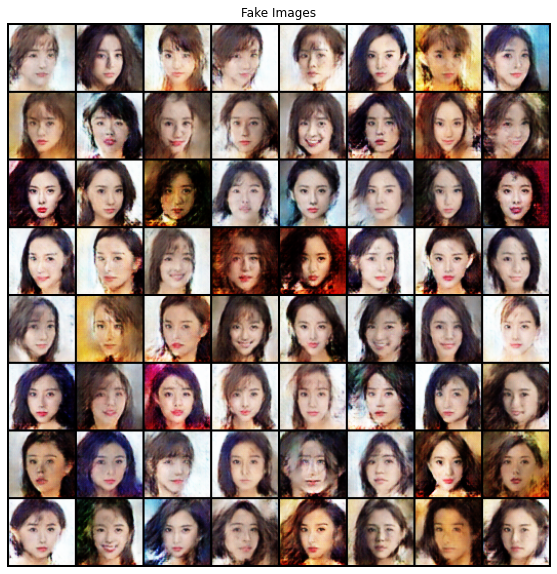

In [5]:
torch.manual_seed(0)
fixed_noise = torch.randn(64, ganconfig.nz, 1, 1, device=device)
img_list = []
with torch.no_grad():
    fake = model(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake[:64], nrow=8, padding=2, normalize=True))
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

### add the difference vector to latent features

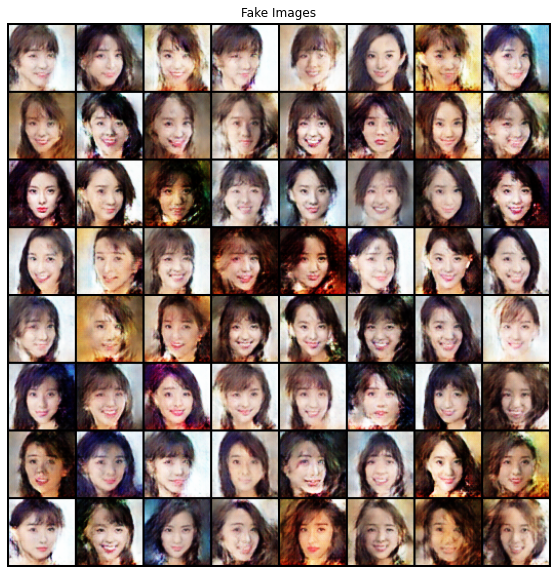

In [6]:
latent_features = fixed_noise
smile_set = latent_features[[12, 26, 35, 37, 57],:]
normal_set = latent_features[[4, 5, 21, 63, 39],:]
# difference vector
diff_vec = torch.mean((smile_set-normal_set),0,True)
# add the difference vector to the latent features
smile_fixed_noise = fixed_noise + diff_vec
# Plot images
img_list = []
with torch.no_grad():
    fake = model(smile_fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake[:64], nrow=8, padding=2, normalize=True))
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

## What features affect the performance?

<AxesSubplot:>

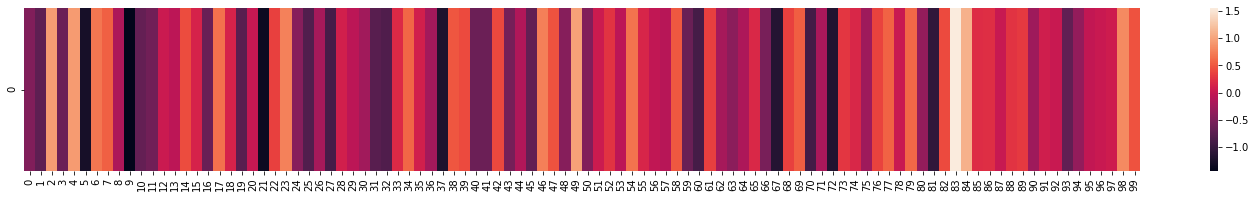

In [7]:
plt.figure(figsize=(25,3))
sns.heatmap(diff_vec.cpu().squeeze(2).squeeze(2).numpy())

##### By the observation, I found that significant differences are at indices [5, 9, 21, 37, 67, 70, 72 81, 83]. But I found that the postive differnece also affect the performance. So I tried to find out both postive and negative difference.

In [8]:
## In this case, I tried to use Kmeans to group the data into 3 cluster(great)
diff_vec_np = diff_vec.cpu().squeeze(2).squeeze(2).numpy().reshape(-1,1)
kmeans = KMeans(n_clusters=3)
kmeans.fit(diff_vec_np)

KMeans(n_clusters=3)

centroid points: p1, p2, p3

        |---------------------------------------------------------------------------|
                   ^                      ^                          ^
                   |                      |                          |
        <==========p1                     p2                         p3=============>


In [13]:
kmeans.cluster_centers_

array([[ 0.00695224],
       [-0.7772555 ],
       [ 0.63837296]], dtype=float32)

In [14]:
print("the number of parameters that greater than the threshold:", np.sum(diff_vec_np>0.63837296))
print("the number of parameters that smaller than the threshold:", np.sum(diff_vec_np<-0.7772555))

the number of parameters that greater than the threshold: 11
the number of parameters that smaller than the threshold: 12


In [15]:
postive_idx = (diff_vec_np>0.63837296).nonzero()[0]
negative_idx = (diff_vec_np<-0.7772555).nonzero()[0]

In [16]:
postive_idx, negative_idx

(array([ 2,  4,  6, 17, 23, 46, 49, 54, 83, 84, 98]),
 array([ 5,  9, 21, 25, 27, 32, 37, 60, 67, 70, 72, 81]))

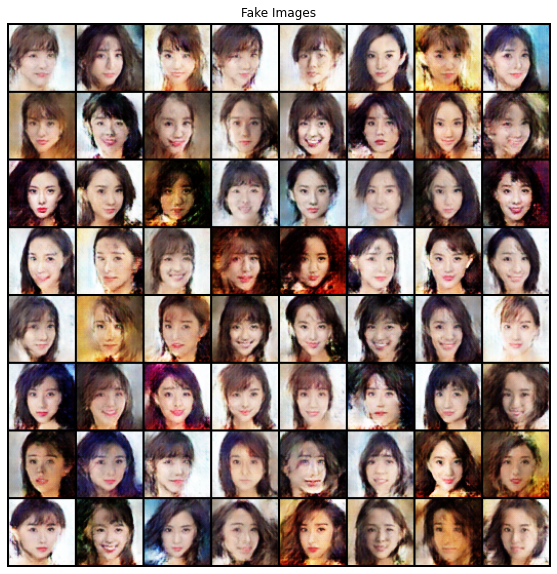

In [17]:
img_list=[]
manual_smile_fixed_noise = fixed_noise
manual_smile_fixed_noise[:,[2,  4,  6, 17, 23, 46, 49, 54, 83, 84, 98],...] += 0.63837296
manual_smile_fixed_noise[:,[5,  9, 21, 25, 27, 32, 37, 60, 67, 70, 72, 81],...] -= 0.7772555
with torch.no_grad():
    fake = model(manual_smile_fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake[:64], nrow=8, padding=2, normalize=True))
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

### Background color

In [14]:
yellow_bgc = [6, 8, 33]
white_bgc = [3, 29, 42]

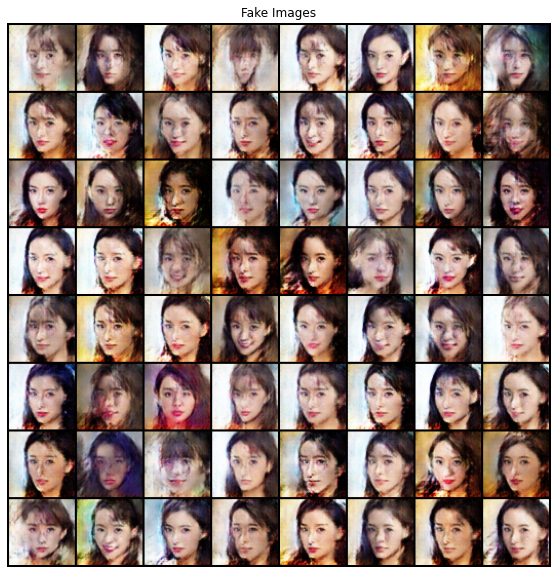

In [15]:
latent_features = fixed_noise
yellow_set = latent_features[yellow_bgc,:]
white_set = latent_features[white_bgc,:]
bgc_img_list = []
# difference vector
bgc_diff_vec = torch.mean((yellow_set-white_set),0,True)
# add the difference vector to the latent features
bgc_fixed_noise = fixed_noise + bgc_diff_vec
# Plot images
img_list = []
with torch.no_grad():
    fake = model(bgc_fixed_noise).detach().cpu()
    bgc_img_list.append(vutils.make_grid(fake[:64], nrow=8, padding=2, normalize=True))
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(bgc_img_list[-1], (1, 2, 0)))
plt.show()

## Discussion

<font size=4 >We can figure out what parameters affect the result of the picture so that we can let the generator generate a particular picture. For example, if we know how to generate a smile, we can emphasize relative parameters to make a smiling face when we are generating a happy song or rock song.</font>


## Video generation

In [40]:
from features.FeaturesLoader import FeaturesLoader
import models.Models as Models
from PIL import Image

In [41]:
audio_model = Models.CRNNModel()
features_loader = FeaturesLoader(torch_model=audio_model, para_file_path="pth/crnnModel1.pth")

loading the model.......


In [42]:
music_features = features_loader.getFeatures("music/prototype.mp3")

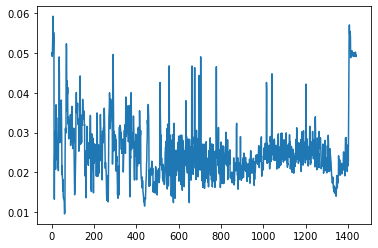

In [43]:
spe_cent = music_features[:,0].numpy()
plt.plot(spe_cent)

In [44]:
torch.manual_seed(1)
latent_features = torch.randn(15, ganconfig.nz, 1, 1)

In [45]:
def smile(features, weight):
    features[:,[2,  4,  6, 17, 23, 46, 49, 54, 83, 84, 98],...] += 0.63837296*weight
    features[:,[5,  9, 21, 25, 27, 32, 37, 60, 67, 70, 72, 81],...] -= 0.7772555*weight
    return features

In [47]:
latent_features_all = torch.zeros(1500, ganconfig.nz, 1, 1)
for idx in range(15):
    latent_features[idx,...] = smile(latent_features[idx,...].unsqueeze(0), music_features[idx*100, 1])
    latent_features_all[idx*100,...] = latent_features[idx,...]

    
for idx in range(14):
    prior_keyimg = latent_features_all[idx*100, ...]
    nex_keyimg = latent_features_all[(idx+1)*100, ...]
    difference_matrix = nex_keyimg-prior_keyimg
    partial_spec_cent = music_features[idx*100:(idx+1)*100,0]
    spec_cent_density = partial_spec_cent/torch.sum(partial_spec_cent)
    for i in range(99):
        latent_features_all[idx*100+i+1,...] = difference_matrix*spec_cent_density[i] + latent_features_all[idx*100+i,...]

for idx in range(1500):
    pic_array = model(latent_features_all[idx,...].unsqueeze(0).to(device)).squeeze().detach().cpu().permute(1,2,0).numpy()
    pic_array = (pic_array-np.min(pic_array))/(np.max(pic_array)-np.min(pic_array))
    plt.imsave('imgs/img%d.jpg' % idx, pic_array)

In [54]:
pic_array = model(prior_keyimg.to(device)).squeeze().detach().cpu().permute(1,2,0).numpy()
pic_array = (pic_array-np.min(pic_array))/(np.max(pic_array)-np.min(pic_array))

In [88]:
spec_cent_density

tensor([0.0095, 0.0108, 0.0110, 0.0128, 0.0117, 0.0114, 0.0102, 0.0140, 0.0133,
        0.0113, 0.0124, 0.0097, 0.0103, 0.0104, 0.0098, 0.0120, 0.0124, 0.0116,
        0.0115, 0.0110, 0.0109, 0.0103, 0.0098, 0.0092, 0.0091, 0.0086, 0.0083,
        0.0083, 0.0088, 0.0090, 0.0082, 0.0080, 0.0077, 0.0080, 0.0076, 0.0072,
        0.0075, 0.0076, 0.0076, 0.0071, 0.0072, 0.0072, 0.0078, 0.0072, 0.0067,
        0.0069, 0.0084, 0.0092, 0.0086, 0.0082, 0.0077, 0.0088, 0.0083, 0.0086,
        0.0092, 0.0092, 0.0116, 0.0108, 0.0108, 0.0101, 0.0102, 0.0111, 0.0106,
        0.0092, 0.0093, 0.0098, 0.0101, 0.0098, 0.0094, 0.0097, 0.0105, 0.0107,
        0.0094, 0.0104, 0.0101, 0.0103, 0.0098, 0.0100, 0.0103, 0.0120, 0.0120,
        0.0113, 0.0109, 0.0109, 0.0106, 0.0101, 0.0092, 0.0093, 0.0129, 0.0137,
        0.0130, 0.0138, 0.0105, 0.0129, 0.0122, 0.0129, 0.0114, 0.0097, 0.0110,
        0.0105])

In [93]:
prior_keyimg.shape

torch.Size([9])

In [53]:
np.min(pic_array)

-0.31353953

In [96]:
latent_features_all.shape

torch.Size([1500, 100, 1, 1])